## ch12 Hyperopt
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.8.1</div>
<div style="text-align: right"> Last update: 2023.8.1</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

새롭게 라이브러리를 로드 하자.

In [2]:
import dtreeviz
from feature_engine import encoding, imputation
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

import xg_helpers as xhelp
from xg_helpers import my_dot_export

In [3]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [4]:
raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')

In [5]:
## Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [6]:
## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

In [7]:
X.head()

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
587,25,18.0,4.0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0
3065,22,16.0,1.0,10000,1,0,0,1,0,0,0,0,1,0,1,0,0,0
8435,22,18.0,1.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3110,40,20.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0
16372,45,12.0,5.0,100000,1,0,1,1,0,0,0,1,0,0,0,1,0,0


In [8]:
y.head()

587      1
3065     0
8435     0
3110     0
16372    1
dtype: int64

Hyperopt uses Bayesian optimization to tune hyperparameters.  

This uses
a probabilistic model to select the next set of hyperparameters to try. If one value performs
better, it will try values around it and see if they boost the performance. If the values worsen
the model, then Hyperopt can ignore those values as future candidates. Hyperopt can also
tune various other machine-learning models, including random forests and neural networks.

### 12.1 Bayesian Optimization

### 12.2 Exhaustive Tuning with Hyperopt

파이썬에서는 함수를 다른 함수에 매개변수로 전달하거나 그 결과로 함수를 반환할 수 있습니다.  
Hyperopt 라이브러리를 사용하려면 많은 하이퍼파라미터 스페이스가 주어졌을 때 최적의 하이퍼파라미터 값을 찾으려고 시도하는 fmin 함수를 사용해야 합니다.

fmin 함수는 평가할 하이퍼파라미터의 딕셔너리를 받아들이고 딕셔너리를 반환하는 다른 함수를 전달할 것으로 예상합니다. 

hyperparameter_tuning 함수는 여기에 적합하지 않습니다. 

이 함수는 첫 번째 매개변수로 공간이라는 사전을 받지만 추가 매개변수가 있습니다. 람다 함수 형태의 클로저를 사용하여 hyperparameter_tuning 함수를 하이퍼파라미터 사전을 받아들이는 새로운 함수에 맞게 조정하겠습니다.

hyperparameter_tuning 함수는 하이퍼파라미터(공간), 훈련 데이터(X_train 및 y_train), 테스트 데이터(X_test 및 y_test), 조기 중지 라운드에 대한 선택적 값(early_stopping_rounds)의 딕셔너리(사전)를 받습니다. 일부 하이퍼파라미터는 정수여야 하므로 해당 키를 변환하고 평가할 하이퍼파라미터에 early_stopping_rounds를 추가합니다.

그런 다음 모델을 훈련하고 정확도 점수가 음수인 사전과 상태를 반환합니다.  
fmin은 점수를 최소화하려고 하고 우리 모델은 정확도를 평가하기 때문에 최소 정확도를 가진 모델을 원하지 않습니다. 그러나 약간의 트릭을 사용하여 음수 정확도를 최소화할 수 있습니다.

In [9]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, roc_auc_score

from typing import Any, Dict, Union

In [10]:
def hyperparameter_tuning(space: Dict[str, Union[float, int]], 
                    X_train: pd.DataFrame, y_train: pd.Series, 
                    X_test: pd.DataFrame, y_test: pd.Series, 
                    early_stopping_rounds: int=50,
                    metric:callable=accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.

    This function takes a dictionary of hyperparameters, training 
    and test data, and an optional value for early stopping rounds, 
    and returns a dictionary with the loss and model resulting from 
    the tuning process. The model is trained using the training 
    data and evaluated on the test data. The loss is computed as 
    the negative of the accuracy score.

    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value 
        is 50.
    metric : callable
        Metric to maximize. Default is accuracy

    Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the 
        tuning process. The loss is a float, and the model is an 
        XGBoost classifier.
    """
    int_vals = ['max_depth', 'reg_alpha']
    space = {k: (int(val) if k in int_vals else val)
             for k,val in space.items()}
    space['early_stopping_rounds'] = early_stopping_rounds
    model = xgb.XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                  (X_test, y_test)]
    model.fit(X_train, y_train,
              eval_set=evaluation, 
              verbose=False)    

    pred = model.predict(X_test)
    score = metric(y_test, pred)
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

최소화하려는 함수를 정의한 후에는 하이퍼파라미터를 검색할 공간을 정의해야 합니다.   

다음으로 하이퍼파라미터 튜닝 프로세스의 결과를 저장하기 위해 traial object를 생성합니다. 
fmin 함수는 옵션을 반복하여 최적의 하이퍼파라미터를 검색합니다.  
여기서는 tree-structured Parzen Estimator, 베이지안 최적화를 실행하는 tpe.suggest 알고리즘을 사용하도록 지시했습니다. 이 
 알고리즘은 expected improvement acquisition function을 사용하여 검색합니다. 
이 알고리즘은 노이즈가 있는 데이터에서 잘 작동합니다.   

또한 검색에 평가 시도를 2,000회로 제한하도록 지시했습니다.  
내 Macbook Pro(2022)에서 이 검색을 실행하는 데 약 30분이 걸렸습니다. 내 Thinkpad P1(2020)에서는 2시간이 넘게 걸립니다. 시간 제한 기간을 설정할 수 있습니다. 로 설정할 수도 있으며, 이 검색이 실행되면 최고의 손실 점수를 뱉어냅니다.

In [11]:
options = {'max_depth': hp.quniform('max_depth', 1, 8, 1),  # tree
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'gamma': hp.loguniform('gamma', -10, 10), # regularization
    'learning_rate': hp.loguniform('learning_rate', -7, 0),  # boosting
    'random_state': 42
}

trials = Trials()

In [12]:
best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, y_train, 
                                                   X_test, y_test),            
    space=options,           
    algo=tpe.suggest,            
    max_evals=2_000,            
    trials=trials,
    #timeout=60*5 # 5 minutes
)

100%|██████████| 2000/2000 [05:15<00:00,  6.34trial/s, best loss: -0.7779005524861878]


best 변수에 결과가 포함된다.   
하이퍼파라미터를 출력해서 보관하자.

In [13]:
# best

주의 : max_depth는 정수이나 실수로 표시됨, 정수로 조정 필요

In [14]:
long_params = {'colsample_bytree': 0.7583844691864223,
 'gamma': 0.0006312831731257507,
 'learning_rate': 0.295815862267789,
 'max_depth': 7,
 'min_child_weight': 5.333178297222369,
 'reg_alpha': 5.486906586611888,
 'reg_lambda': 1.1524178084577712,
 'subsample': 0.9721881017707349}

In [15]:
xg_ex = xgb.XGBClassifier(**long_params, early_stopping_rounds=50,
n_estimators=500)
xg_ex.fit(X_train, y_train,
eval_set=[(X_train, y_train),
(X_test, y_test)
],
verbose=100
)

[0]	validation_0-logloss:0.63367	validation_1-logloss:0.63390
[100]	validation_0-logloss:0.46775	validation_1-logloss:0.49044
[200]	validation_0-logloss:0.45785	validation_1-logloss:0.48906
[260]	validation_0-logloss:0.45484	validation_1-logloss:0.48893


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7583844691864223, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0006312831731257507, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.295815862267789, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5.333178297222369, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [16]:
xg_ex.score(X_test, y_test)

0.7657458563535912

### 12.3 Defining Parameter Distributions

하이퍼파라미터를 옵션 목록에서 선택하는 것으로 제한하는 대신, 하이퍼옵트 라이브러리에는 값 선택 방법을 정의할 수 있는 다양한 함수가 있습니다.

선택 함수는 범주형 하이퍼파라미터에 대해 불연속적인 값 집합을 지정할 수 있습니다.   
이는 그리드 검색에서 옵션 목록을 열거하는 것과 유사합니다.   

이 함수는 가능한 값의 목록과 이러한 값에 대한 선택적 확률 분포라는 두 가지 인수를 받습니다.

이 함수는 지정된 확률 분포에 따라 목록에서 임의의 값을 반환합니다.

예를 들어 가능한 값 목록 ['a', 'b', 'c']에서 임의의 값을 생성하려면 다음과 같이 코드를 사용하면 됩니다, 다음 코드를 사용할 수 있습니다:

In [17]:
from hyperopt import hp, pyll

In [18]:
pyll.stochastic.sample(hp.choice('value', ['a', 'b', 'c']))

'b'

가능한 값을 확률 분포로 출력하려면

In [19]:
pyll.stochastic.sample(hp.pchoice('value', [(.05, 'a'), (.9, 'b'), (.05, 'c')]))

'b'

- 중요 : 수치형 데이터에 대해서는 choice, pchoice 사용하는 것을 주의 해야 한다.  Hyperopt 라이브러리는 각 값을 순서가 아닌 독립적인 값으로 취급합니다. 검색 알고리즘은 인접한 값의 결과를 활용할 수 없습니다. 
   
Hyperopt를 사용하는 예제에서 다음과 같이 'num_leaves' 및 'subsample'에 대한 검색 공간을 정의할 것을 제안합니다:   

```python
'num_leaves': hp.choice('num_leaves', list(range(20, 250, 10))),
'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
```

그런데 위와 같이 사용하면 안된다. 다음과 같이 설정하여 Hyperopt가 효율적으로 스페이스를 탐색할 수 있도록 해야한다.
```python
'num_leaves': hp.quniform('num_leaves', 20, 250, 10),
'subsample': hp.uniform('subsample', 0.2, .9),
```


uniform 함수는 연속적인 값 범위에 걸쳐 균일한 분포를 지정할 수 있습니다.

이 함수는 uniform 분포의 최소값과 최대값이라는 두 개의 인수를 받고 이 범위 내에서 임의의 부동 소수점 값을 반환합니다.

예를 들어 uniform 함수를 사용하여 0과 1 사이의 임의의 부동 소수점 값을 생성하려면 함수를 사용하여 0과 1 사이의 임의의 부동 소수점 값을 생성하려면 다음 코드를 사용할 수 있습니다:

In [20]:
from hyperopt import hp, pyll

In [21]:
pyll.stochastic.sample(hp.uniform('value', 0, 1))

0.6820853376526433

10000번을 진행하고 히스토그램을 그려보자.

(array([ 980., 1041.,  990.,  985., 1037.,  968.,  982.,  971., 1069.,
         977.]),
 array([2.15582103e-04, 1.00178844e-01, 2.00142106e-01, 3.00105368e-01,
        4.00068631e-01, 5.00031893e-01, 5.99995155e-01, 6.99958417e-01,
        7.99921679e-01, 8.99884941e-01, 9.99848203e-01]),
 <BarContainer object of 10 artists>)

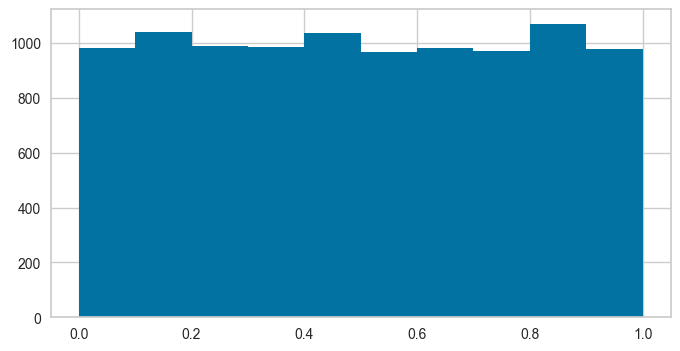

In [22]:
uniform_vals = [pyll.stochastic.sample(hp.uniform('value', 0, 1)) for _ in range(10000)]
fig, ax = plt.subplots(figsize = (8, 4))
ax.hist(uniform_vals)

로그 균등 함수는 연속적인 값 범위에서 로그 균등 분포를 지정할 수 있습니다. 이 함수는 로그 균등 분포의 최소값과 최대값이라는 두 개의 인수를 받으며, 이 범위 내에서 임의의 부동 소수점 값을 로그 배율로 반환합니다.
다음은 -5에서 5까지의 로그 균등 값에 대한 히스토그램입니다. 이 값은 -5에서 5까지의 범위가 아니라 0.006737(math.exp(-5))에서 148.41(math.exp(5))까지입니다. 이 값은 로우엔드에 매우 유리합니다.

(array([7672.,  669.,  410.,  332.,  230.,  185.,  151.,  128.,  121.,
         102.]),
 array([6.73984440e-03, 1.48412066e+01, 2.96756734e+01, 4.45101402e+01,
        5.93446070e+01, 7.41790738e+01, 8.90135406e+01, 1.03848007e+02,
        1.18682474e+02, 1.33516941e+02, 1.48351408e+02]),
 <BarContainer object of 10 artists>)

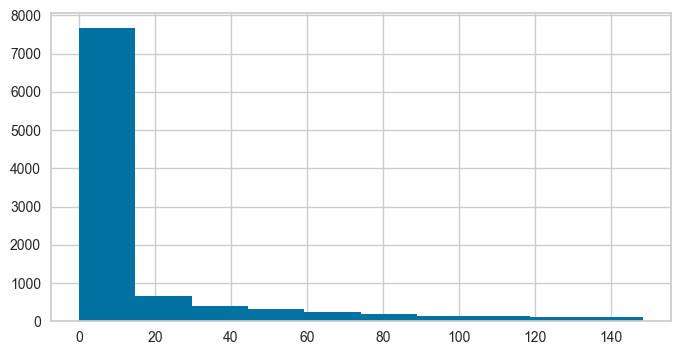

In [23]:
loguniform_vals = [pyll.stochastic.sample(hp.loguniform('value', -5, 5))
for _ in range(10_000)]
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(loguniform_vals)

<Axes: xlabel='x'>

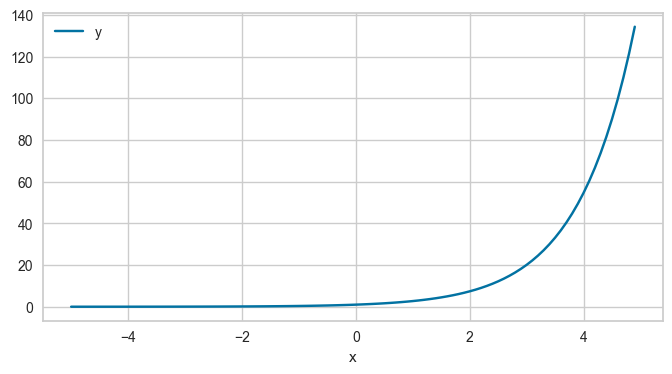

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(np.arange(-5, 5, step=.1))
.rename('x')
.to_frame()
.assign(y=lambda adf:np.exp(adf.x))
.plot(x='x', y='y', ax=ax)
)

예를 들어 랜덤 부동 소수점 값을 만들어 보자. 0.1 ~ 10 범위 값을 loguniform 함수를 통해서 만들어 보자.

In [25]:
from hyperopt import hp, pyll
from math import log

In [26]:
pyll.stochastic.sample(hp.loguniform('value', log(.1), log(10)))

0.33357505595647147

.001, .01, .1, 1, 10 등 로그 눈금에서 값을 가져오려면 loguniform을 사용합니다.

quniform 함수를 사용하여 [exp(low), exp(high)] 범위의 정수를 지정할 수 있습니다. 이 함수는 단계를 지정하는 q 매개 변수를 사용할 수도 있습니다(q=1의 경우 범위의 모든 정수를 반환합니다. q=3의 경우 세 번째 정수마다 반환합니다.)

In [27]:
quniform_vals = [pyll.stochastic.sample(hp.quniform('value', -5, 5, q=2))
for _ in range(10_000)]

In [28]:
pd.Series(quniform_vals).value_counts()

 4.0    2029
-0.0    2025
-2.0    2013
 2.0    1968
-4.0    1965
Name: count, dtype: int64

### 12.4 Exploring the Trials

hyper opt의 trial 객체는 하이퍼파라미터의 최적화에 필요한 데이터를 가진다.   
사용하는데 필요없으므로 이부분은 스킵해도됨.   


  
  
trial을 데이터프레임으로 만들어보자.

In [29]:
from typing import Any, Dict, Sequence

In [30]:
def trial2df(trial: Sequence[Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert a Trial object (sequence of trial dictionaries)
    to a Pandas DataFrame.

    Parameters
    ----------
    trial : List[Dict[str, Any]]
        A list of trial dictionaries.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns for the loss, trial id, and
        values from each trial dictionary.
    """
    vals = []
    for t in trial:
        result = t['result']
        misc = t['misc']
        val = {k:(v[0] if isinstance(v, list) else v)  
               for k,v in misc['vals'].items()
              }
        val['loss'] = result['loss']
        val['tid'] = t['tid']
        vals.append(val)
    return pd.DataFrame(vals)

In [31]:
trials

In [32]:
hyper2hr = trial2df(trials)

In [33]:
hyper2hr

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,subsample,loss,tid
0,0.900694,4157.242357,0.254379,8.0,1.434767,2.911688,7.676577,0.818594,-0.545856,0
1,0.883721,0.314668,0.010007,7.0,11.521516,3.851235,5.197805,0.912120,-0.739227,1
2,0.973376,207.261765,0.111203,2.0,0.417812,5.873439,6.025686,0.504501,-0.545856,2
3,0.889420,0.019365,0.001137,8.0,14.532049,6.825019,3.977222,0.530029,-0.731492,3
4,0.709597,0.253780,0.012011,4.0,9.562295,5.587390,5.923663,0.777127,-0.744751,4
...,...,...,...,...,...,...,...,...,...,...
1995,0.766985,0.066012,0.211147,5.0,0.277207,3.629037,5.199182,0.912566,-0.765746,1995
1996,0.784537,0.012728,0.123177,4.0,0.328031,2.704238,4.715335,0.966307,-0.760221,1996
1997,0.710885,0.332473,0.190171,6.0,0.158567,5.231494,3.759287,0.929219,-0.759116,1997
1998,0.725875,0.149074,0.172976,6.0,0.193659,0.410314,3.679801,0.903856,-0.754696,1998


이제 하이퍼파라미터가 서로간 상관관계가 있는지 살펴보자.

<Axes: >

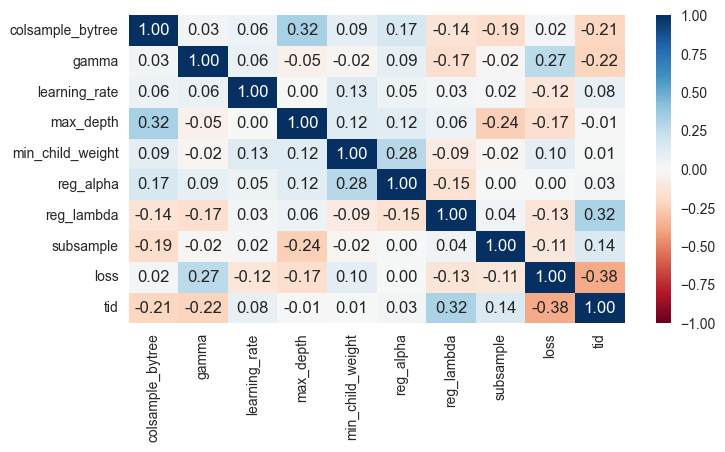

In [34]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(hyper2hr.corr(method='spearman'),
cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
)

loss와 tid(trial ID) 사이에는 음의 상관 관계가 있습니다. 이는 예상되는 결과입니다.  
진행이 진행됨에 따라 음의 손실 점수는 감소해야 합니다.  
최적화 프로세스는 negative loss를 최소화하기 위해 exploration와 expoitation의 균형을 맞춰야 합니다. 

이 두 열의 분산형 차트를 보면 이런 현상이 나타납니다.  
때때로 탐색 시도가 좋지 않은 것으로 판명되면(손실 값이 -0.55 정도) 베이지안 탐색 프로세스가 더 나은 값으로 되돌아갑니다.

<Axes: xlabel='tid', ylabel='loss'>

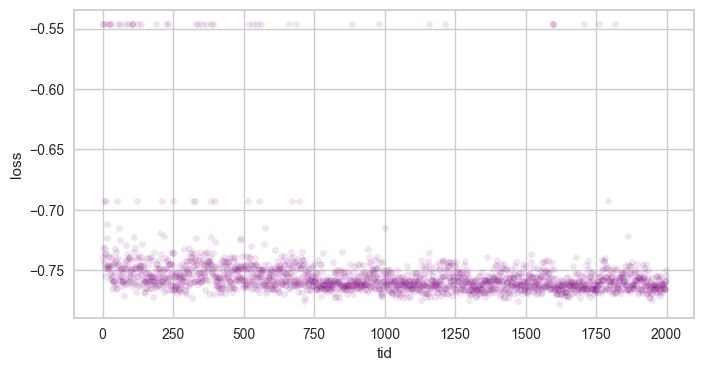

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
.plot.scatter(x='tid', y='loss', alpha=.1, color='purple', ax=ax)
)

상관도가 -0.13 인 max_depth and olss를 살펴보자.

<Axes: xlabel='max_depth', ylabel='loss'>

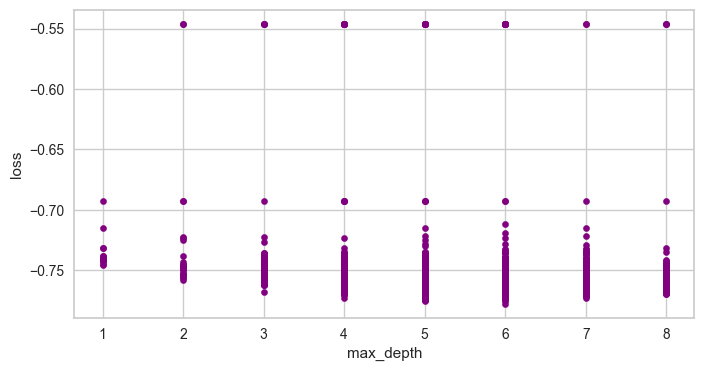

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
.plot.scatter(x='max_depth', y='loss', alpha=1, color='purple', ax=ax)
)

max_depth 값이 서로 겹쳐서 표시되기 때문에 이해하기 조금 어렵습니다. 지터링이라는 기법을 사용하여 두 값을 분리하고 얼마나 많은 값이 있는지 파악할 수 있도록 하겠습니다. 또한 값이 겹치는 부분을 볼 수 있도록 플롯의 알파 값을 조정하겠습니다. 

제가 사용한 지터 함수는 다음과 같습니다. 데이터 포인트 주위에 임의의 양의 노이즈를 추가합니다. 이제 max_depth 열에 적용해 보겠습니다.

In [37]:
import numpy as np

def jitter(df: pd.DataFrame, col: str, amount: float=1) -> pd.Series:
    """
    Add random noise to the values in a Pandas DataFrame column.

    This function adds random noise to the values in a specified 
    column of a Pandas DataFrame. The noise is uniform random 
    noise with a range of `amount` centered around zero. The 
    function returns a Pandas Series with the jittered values.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    col : str
        The name of the column to jitter.
    amount : float, optional
        The range of the noise to add. The default value is 1.

    Returns
    -------
    pd.Series
        A Pandas Series with the jittered values.
    """
    vals = np.random.uniform(low=-amount/2, high=amount/2,
                            size=df.shape[0])
    return df[col] + vals

<Axes: xlabel='max_depth', ylabel='loss'>

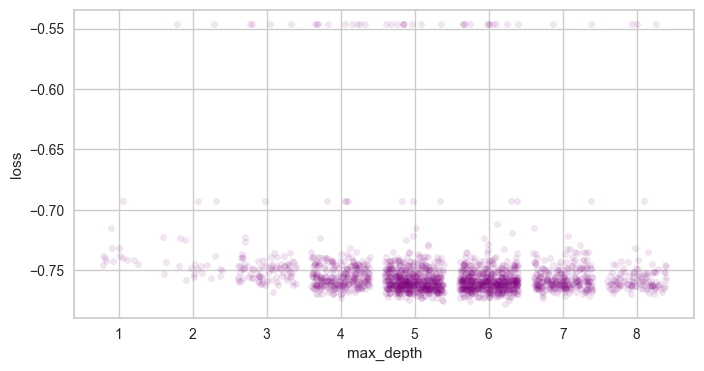

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
.assign(max_depth=lambda df:jitter(df, 'max_depth', amount=.8))
.plot.scatter(x='max_depth', y='loss', alpha=.1, color='purple', ax=ax)
)

- 이제 해석하기 편해졌다.  
- depth 6 근처에서 많은 시간을 소비한 것을 알 수 있다.

In [42]:
hyper2hr.dtypes

colsample_bytree    float64
gamma               float64
learning_rate       float64
max_depth           float64
min_child_weight    float64
reg_alpha           float64
reg_lambda          float64
subsample           float64
loss                float64
tid                   int64
dtype: object

<Axes: xlabel='max_depth', ylabel='loss'>

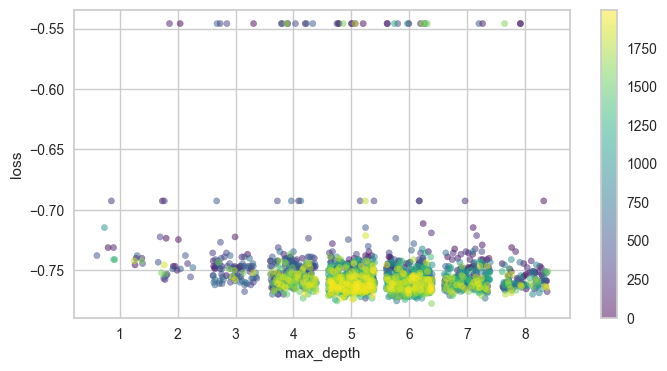

In [44]:
# 코드 수정 필요
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
.assign(max_depth=lambda df:jitter(df, 'max_depth', amount=.8))
.plot.scatter(x='max_depth', y='loss', alpha=.5,
color= hyper2hr['tid'], cmap='viridis', ax=ax)
)

<Axes: xlabel='max_depth', ylabel='loss'>

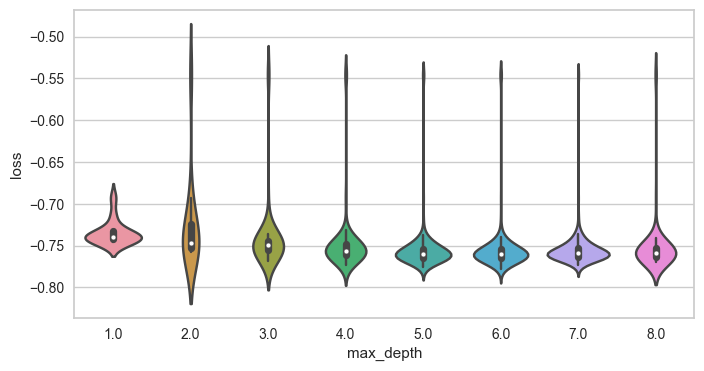

In [45]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(x='max_depth', y='loss', data=hyper2hr, kind='violin', ax=ax)

reg_alpha와 colsample_bytree 간의 상관관계는 0.41로, 다른 값의 순위가 올라가면 한 값의 순위가 올라가는 경향이 약간 있었습니다.   
이것을 플롯하여 인사이트를 얻을 수 있는지 살펴보겠습니다.

Text(0.7, 0.84, 'Min Loss (-0.77)')

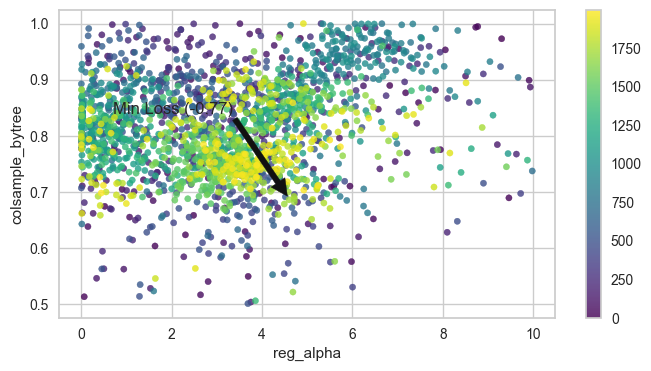

In [47]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
.plot.scatter(x='reg_alpha', y='colsample_bytree', alpha=.8,
color=hyper2hr['tid'], cmap='viridis', ax=ax)
)
ax.annotate('Min Loss (-0.77)', xy=(4.56, 0.692),
xytext=(.7, .84), arrowprops={'color':'k'})

<Axes: xlabel='gamma', ylabel='loss'>

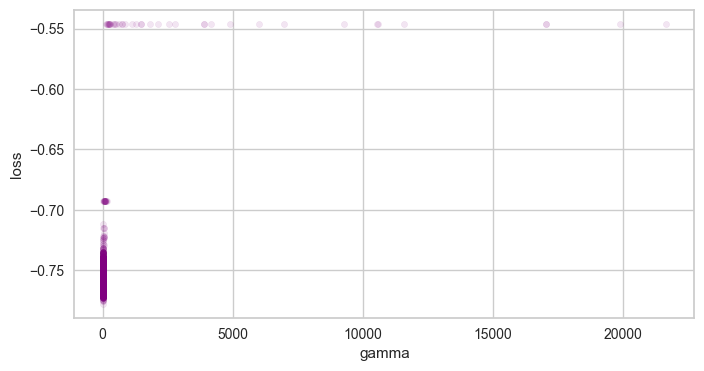

In [48]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
.plot.scatter(x='gamma', y='loss', alpha=.1, color='purple', ax=ax)
)

Text(1, -0.6, 'Min Loss (-0.77)')

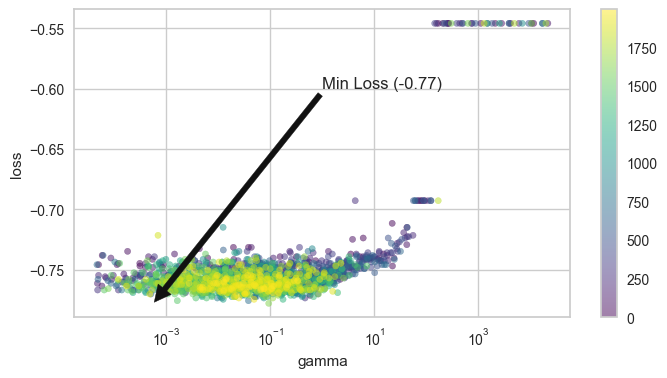

In [50]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
.plot.scatter(x='gamma', y='loss', alpha=.5, color=hyper2hr['tid'], ax=ax,
logx=True, cmap='viridis')
)
ax.annotate('Min Loss (-0.77)', xy=(0.000581, -0.777),
xytext=(1, -.6), arrowprops={'color':'k'})

### 12.5 EDA with Plotly

In [51]:
import plotly.graph_objects as go

def plot_3d_mesh(df: pd.DataFrame, x_col: str, y_col: str, 
                 z_col: str) -> go.Figure:
    """
    Create a 3D mesh plot using Plotly.

    This function creates a 3D mesh plot using Plotly, with 
    the `x_col`, `y_col`, and `z_col` columns of the `df` 
    DataFrame as the x, y, and z values, respectively. The 
    plot has a title and axis labels that match the column 
    names, and the intensity of the mesh is proportional 
    to the values in the `z_col` column. The function returns 
    a Plotly Figure object that can be displayed or saved as 
    desired.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data to plot.
    x_col : str
        The name of the column to use as the x values.
    y_col : str
        The name of the column to use as the y values.
    z_col : str
        The name of the column to use as the z values.

    Returns
    -------
    go.Figure
        A Plotly Figure object with the 3D mesh plot.
    """
    fig = go.Figure(data=[go.Mesh3d(x=df[x_col], y=df[y_col], z=df[z_col],
        intensity=df[z_col]/ df[z_col].min(),
        hovertemplate=f"{z_col}: %{{z}}<br>{x_col}: %{{x}}<br>{y_col}: "
                                    "%{{y}}<extra></extra>")],
    )

    fig.update_layout( 
        title=dict(text=f'{y_col} vs {x_col}'),
        scene = dict(
          xaxis_title=x_col,
          yaxis_title=y_col,
          zaxis_title=z_col),
        width=700,
        margin=dict(r=20, b=10, l=10, t=50)
    )
    return fig

In [52]:
fig = plot_3d_mesh(hyper2hr.query('gamma < .2'),
    'reg_lambda', 'gamma', 'loss')

fig

In [53]:
import plotly.express as px
import plotly.graph_objects as go

def plot_3d_scatter(df: pd.DataFrame, x_col: str, y_col: str, 
                 z_col: str, color_col: str, 
                 opacity: float=1) -> go.Figure:
    """
    Create a 3D scatter plot using Plotly Express.

    This function creates a 3D scatter plot using Plotly Express, 
    with the `x_col`, `y_col`, and `z_col` columns of the `df` 
    DataFrame as the x, y, and z values, respectively. The points 
    in the plot are colored according to the values in the 
    `color_col` column, using a continuous color scale. The 
    function returns a Plotly Express scatter_3d object that 
    can be displayed or saved as desired.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data to plot.
    x_col : str
        The name of the column to use as the x values.
    y_col : str
        The name of the column to use as the y values.
    z_col : str
        The name of the column to use as the z values.
    color_col : str
        The name of the column to use for coloring.
    opacity : float
        The opacity (alpha) of the points.

    Returns
    -------
    go.Figure
        A Plotly Figure object with the 3D mesh plot.
    """
    fig = px.scatter_3d(data_frame=df, x=x_col,
                y=y_col, z=z_col, color=color_col,
                color_continuous_scale=px.colors.sequential.Viridis_r,
                opacity=opacity)
    return fig

In [54]:
plot_3d_scatter(hyper2hr.query('gamma < .2'), 
              'reg_lambda', 'gamma', 'tid', color_col='loss')
